# **Resultado móvil de la balanza energética**

---



El presente archivo contiene el código utilizado para obtener, procesar y analizar los datos correspondientes al Balance Cambiario, publicado mensualmente por el Banco Central de la República Argentina (BCRA).

El Balance Cambiario recoge datos de las compras y ventas de moneda extranjera realizadas en el mercado de cambios formal. Se subdivide en numerosas aperturas, que dan cuenta de la multiplicidad de actividades económicas. En particular, se analizará la evolución de 3 partidas: electricidad, gas y petróleo.

Como resultado del análisis, se presenta una figura en forma de gráfico de línea rellena (área bajo/sobre línea) que permite visualizar los períodos y niveles de superávit/déficit del balance cambiario-energético.

## Preliminar

### Importación de *libraries*

Se importan las *libraries* a utilizar en el código.

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
import datetime as dt
from datetime import date

### Exportación a archivo `.pdf`

En caso de precisarse exportar las figuras resultantes a formato `.pdf`, se debe instalar el *package* `kaleido`.

**IMPORTANTE**: para evitar problemas de desconexión, es recomendable ejecutar el código la siguiente celda y, una vez terminado el proceso de instalación, reiniciar el entorno de ejecución y ejecutar todas las celdas.

In [2]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.6 MB/s eta 0:00:00


## Resultado móvil de la balanza energética

### Obtención de datos y *DataFrame* final

Los datos del balance cambiario son publicados mensualmente por el Banco Central de la República Argentina (BCRA), en el Informe de la Evolución del Mercado de Cambios y Balance Cambiario.

En conjunto con dicho informe, es publicado el Anexo estadístico del balance cambiario, que contiene un desglose de todas las operaciones de cambio, desagregadas por apertura.

El link `url_balance` refiere a dicho archivo.

**Nota**: Desde el mes de abril del año 2023, se publica el nuevo anexo estadístico del mercado de cambios y balance cambiario, discontinuando las publicaciones anteriores desde el 28 de dicho mes.

In [3]:
url_balance = "https://www.bcra.gob.ar/Pdfs/PublicacionesEstadisticas/Nuevo-anexo-MC.xlsm"

A partir de `url_balance`, se utiliza `pandas` para leer la hoja "Datos Mercado de Cambios" del archivo, utilizando solo las columnas deseadas.

In [4]:
balance = pd.read_excel(url_balance, sheet_name="Datos Mercado de Cambios", usecols=[1, 2, 3])

La base de datos contiene todos los ingresos y egresos registrados en el Mercado de Cambios. Para este análisis, solo son relevantes aquellos relacionados con el sector energético. Estos sectores se almacenan en la lista `energy`.

In [5]:
energy = ["Electricidad (Generación, Transporte, Distribución)",
          "Gas (Extracción, Transporte, Distribución)",
          "Petróleo"]

Se filtra el *DataFrame* para que contenga solo aquellas observaciones en las que la columna "Sector" sea una variable de interés.

In [6]:
balance = balance[balance["Sector"].isin(energy)]

Se agrupa según el período ("Mes") utilizando `sum()` (suma) como función de agregación.

In [7]:
balance = balance.groupby(["Mes"], as_index=False)["Monto"].sum()

La columna "Monto" está expresada en US\$. Para expresarla en millones de US\$, se la divide por 1.000.000.

In [8]:
balance["Monto"] = balance["Monto"]/1000000

Se crea una media móvil de 12 meses sobre la columna "Monto".

In [9]:
balance['RAvg_12m'] = balance['Monto'].rolling(12).sum()

Se eliminan las columnas innecesarias.

In [10]:
balance = balance[['Mes', 'RAvg_12m']]

Así, queda creado el *DataFrame* que contiene el índice temporal y la media móvil anual.

A continuación, se presentan las primeras 5 filas de dicho *DataFrame*.

In [11]:
balance.head()

,Mes,RAvg_12m
0,2003-01-01,NaN
1,2003-02-01,NaN
2,2003-03-01,NaN
3,2003-04-01,NaN
4,2003-05-01,NaN


Nótese que, por la ventana de 12 meses, las primeras 5 filas arrojan `NaN`. Sin embargo, las últimas 5 filas sí muestran valores correctos.

In [12]:
balance.tail()

,Mes,RAvg_12m
238,2022-11-01,-8243.193684
239,2022-12-01,-8382.347050
240,2023-01-01,-8510.007774
241,2023-02-01,-8359.969299
242,2023-03-01,-7925.158810


Por último, se exporta el *DataFrame* en formato `.xlsx`.

In [13]:
balance.to_excel("Resultado móvil de la balanza energética.xlsx", index=False)

## Figura: Resultado móvil de la balanza energética

El resultado acumulado móvil anual puede indicar un superávit (generalmente representado con el color verde) o un déficit (color rojo), para cada mes del año. Se definen, así, los colores.

In [14]:
green = "#66AA00"
red = "#B82E2E"

Para facilitar la visualización, es necesario agregar dos columnas al *DataFrame* original: la primera, "superavit", toma el valor del resultado acumulado móvil cuando el balance toma valores positivos; la segunda, "deficit", hace lo mismo para los valores negativos de la serie.

In [15]:
balance['superavit'] = balance["RAvg_12m"].where(balance["RAvg_12m"] > 0)
balance['deficit'] = balance["RAvg_12m"].where(balance["RAvg_12m"] < 0)

Se crea la figura `balance_fig` en el entorno de Plotly (utilizando `graph_objects` como `go`).

In [16]:
balance_fig = go.Figure()

Al tratarse de una sola figura, en este caso, no se define una función, sino que las especificaciones de la figura se encuentran en el argumento de ésta.

In [17]:
for column, color in zip(balance.columns[2:], [green, red]):
  balance_fig.add_trace(
    go.Scatter(
    showlegend=False,
    mode='lines',
    name=column,
    x=balance[balance.columns[0]],
    y=balance[column],
    line=dict(color=color),
    fill='tozeroy')
    )

balance_fig.add_trace(
  go.Scatter(
    mode='lines',
    showlegend=True,
    name="Resultado acumulado móvil - 12 meses",
    x=[dt.date(2001, 3, 30), dt.date(2002, 3, 30)],
    y=[0, 1],
    marker=dict(color="lightgray")))


balance_fig.add_trace(
  go.Scatter(
    showlegend=False,
    x=balance[balance.columns[0]].tail(1),
    y=balance["RAvg_12m"].tail(1),
    mode='markers',
    marker=dict(color=red, size=10),
    name=" - EoP"
    )
)

balance_fig.add_annotation(
  x=balance[balance.columns[0]][len(balance)-1],
  y=balance["RAvg_12m"][-1:].values[0],
  text=round(balance["RAvg_12m"][-1:].values[0], 2).astype(str),
  font=dict(color=red),
  xanchor="left",
  xshift=7.5,
  yshift=0,
  showarrow=False
  )

balance_fig = balance_fig.update_layout(
    margin=dict(b=15, t=15, l=15, r=60),
    height=750, 
    width=1000, 
    yaxis_title="<b>M USD",
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(
        orientation='h',
        xanchor='center', 
        x=0.5, 
        yanchor='bottom', 
        y=1,
        font=dict(size=16)
        ),
    xaxis=dict(
        range=[balance[balance.columns[0]][0], dt.date(date.today().year, date.today().month, 1)],
        tickformat="%m<br><b>%Y", dtick="M12",
        ),
    yaxis=dict(
        dtick="1000",
        showgrid=True,
        gridcolor="lightgray",
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor="gray"
        ),
    font=dict(
        size=14,
        family="Serif"
        )
    )

A continuación, se exhibe la figura.

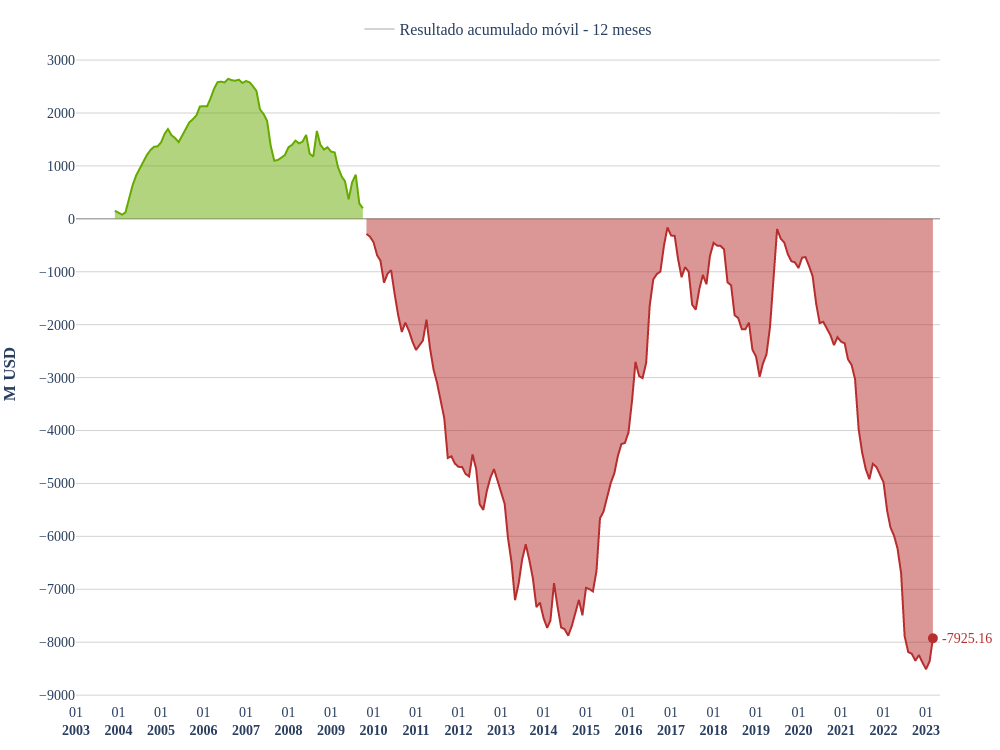

In [18]:
balance_fig.show("png")

Si se desea exportar la figura a formato `.pdf`, se debe des-comentar y ejecutar la siguiente celda. Recuérdese que el *package* `kaleido` debe estar correctamente instalado.

In [19]:
pio.write_image(balance_fig, "Figura Balance Energetico (acum. anual).pdf", width=3*300, height=2.25*300)